In [90]:
from openai import OpenAI
import pandas as pd


In [82]:

SYSTEM_PROMPT = """
Rewrite the provided user query into multiple subqueries that will likely retrieve the documents that answer the original question.
Do not use SQL queries; use only text phrases.
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
subquerytext||subquerytext||subquerytext
</answer>
"""

def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

In [91]:
import json
from datasets import Dataset
from typing import Dict, List, Any


def extract_subqueries(text: str) -> List[str]:
    """
    Extract subqueries from text, returning empty list if parsing fails.

    Expected format: <answer>query1||query2||query3</answer>

    Args:
        text: Input text containing subqueries

    Returns:
        List of extracted subqueries, or empty list if parsing fails
    """
    try:
        # Check if text is valid
        if not text or not isinstance(text, str):
            return []

        # Check if required tags exist
        if "<answer>" not in text or "</answer>" not in text:
            return []

        # Split and extract content between tags
        parts = text.split("<answer>")
        if len(parts) < 2:
            return []

        # Get content after <answer> tag
        content_after_start = parts[1]

        # Split on </answer> tag
        parts = content_after_start.split("</answer>")
        if len(parts) < 1:
            return []

        # Get content between the tags
        content_between_tags = parts[0]

        # Split on delimiter and clean up
        if "||" in content_between_tags:
            subqueries = [query.strip() for query in content_between_tags.split("||")]
            # Filter out empty queries
            subqueries = [query for query in subqueries if query]
            return subqueries
        else:
            # Single query case (no || delimiter)
            single_query = content_between_tags.strip()
            return [single_query] if single_query else []

    except (IndexError, AttributeError, ValueError) as e:
        print(f"Warning: Failed to extract subqueries from text: {e}")
        return []
    except Exception as e:
        print(f"Warning: Unexpected error in extract_subqueries: {e}")
        return []

def get_reasoning_questions(split: str = "train", test_size: int = 50) -> Dataset:
    """
    Load reasoning questions from combined_reasoning_traces.jsonl

    Args:
        split: Either "train" or "test"/"validation"
        test_size: Number of examples to hold out for test/validation
    """
    data = []

    # Load data from JSONL file
    with open("input-data/combined_reasoning_traces.jsonl", "r") as f:
        for line in f:
            data.append(json.loads(line.strip()))

    # Split data - last test_size examples for validation/test
    if split == "train":
        examples = data[:-test_size]
    elif split in ["test", "validation"]:
        examples = data[-test_size:]
    else:
        raise ValueError(f"Split must be 'train', 'test', or 'validation', got {split}")

    # Transform to the expected format
    def format_example(example: Dict[str, Any]) -> Dict[str, Any]:
        return {
            'prompt': [
                {'role': 'system', 'content': SYSTEM_PROMPT},
                {'role': 'user', 'content': example['question']}
            ],
            'reasoning': example['reasoning'],
            'subqueries': example['subqueries'],
            'answer_chunks': example['answer_chunks'],
            'chunk_ids': example['chunk_ids'],
            'index': example['index']
        }

    # Create dataset
    formatted_data = [format_example(example) for example in examples]
    return Dataset.from_list(formatted_data)

# Usage examples:
dataset_train = get_reasoning_questions("train").shuffle()  # 201 examples
dataset_test = get_reasoning_questions("test")    # 50 examples

print(f"Train size: {len(dataset_train)}")
print(f"Test size: {len(dataset_test)}")

Train size: 200
Test size: 50


In [4]:
dataset_test[0]

{'prompt': [{'content': '\nRewrite the provided user query into multiple subqueries that will likely retrieve the documents that answer the original question.\nDo not use SQL queries; use only text phrases.\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\nsubquerytext||subquerytext||subquerytext\n</answer>\n',
   'role': 'system'},
  {'content': "What was Google's original name and how did its founders' vision influence the company's ultimate mission?",
   'role': 'user'}],
 'reasoning': "To answer the question, I need to identify two key pieces of information: Google's original name and the connection between its founders' initial vision and the company's ultimate mission. I will formulate subqueries to extract each of these components from the provided text.",
 'subqueries': ['What was the original name of Google?',
  "What was the initial vision of Google's founders, Larry Page and Sergey Brin?",
  "How did the founders' vision influence or guide Google's

In [93]:
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizedQuery
import os
from openai import AzureOpenAI

import os
import dotenv

dotenv.load_dotenv()


# Replace with your actual endpoint and API key
endpoint = os.environ.get("AZURE_SEARCH_SERVICE_ENDPOINT")
api_key = os.environ.get("AZURE_SEARCH_SERVICE_KEY")

# List of index names
index_names = [
    "african_jungle",
    "asian_history",
    "big_tech",
    "classical_civilizations",
    "trading_and_tax",
]

# Initialize a dictionary to hold the SearchClient instances
search_clients: Dict[str, SearchClient] = {}

# Loop through the index names and initialize a SearchClient for each
for index_name in index_names:
    search_client = SearchClient(
        endpoint=endpoint,
        index_name=index_name,
        credential=AzureKeyCredential(api_key)
    )
    search_clients[index_name] = search_client
    print(f"Initialized SearchClient for index: {index_name}")

# You can now access each client by its index name, e.g.:
# african_jungle_client = search_clients["african_jungle"]
# big_tech_client = search_clients["big_tech"]

# Configure OpenAI client
client = AzureOpenAI(
    api_key = os.environ.get("AZURE_OPENAI_KEY"),
    api_version = "2024-02-01",
    azure_endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT")
)

def generate_embedding(texts, model="text-embedding-3-small"):
    # Clean and filter inputs
    if isinstance(texts, str):
        texts = [texts]

    cleaned = [str(t).strip() for t in texts if t and str(t).strip()]

    if not cleaned:
        return []

    return client.embeddings.create(input=cleaned, model=model).data


Initialized SearchClient for index: african_jungle
Initialized SearchClient for index: asian_history
Initialized SearchClient for index: big_tech
Initialized SearchClient for index: classical_civilizations
Initialized SearchClient for index: trading_and_tax


In [23]:

def conduct_retrieval(subqueries, index) -> list[int]:
    search_client = search_clients[index]
    res = []

    embs = [r.embedding for r in generate_embedding(subqueries)]
    for q, emb in zip(subqueries, embs):
        try:
            vector_query = VectorizedQuery(vector=emb, k_nearest_neighbors=50, fields="text_vector")

            results = search_client.search(
                q,
                top=5,
                select="chunk_id",
                vector_queries=[vector_query]
            )
            for result in results:
                res.append(int(result['chunk_id']))
        except Exception as e:
            print(f"Warning: Search failed for query '{q}': {e}")

    return res

In [24]:
def retrieval_recall_reward_func(prompt, response, chunk_ids, index,
                                recall_threshold: float = 0.7, **kwargs) -> float:
    """
    Binary reward version - gives full reward if recall exceeds threshold.
    
    Args:
        prompt: Single prompt (list of messages)
        response: Single response string from LLM
        chunk_ids: Expected chunk IDs for this example
        index: Index name for retrieval
        recall_threshold: Minimum recall needed for full reward (default 0.7)
    
    Returns:
        Single float reward value
    """
    question = prompt[-1]['content']
    
    try:
        extracted_queries = extract_subqueries(response)
        retrieved_results = conduct_retrieval(extracted_queries, index)

        # Extract retrieved chunk IDs - handle various formats
        retrieved_chunk_ids = set()
        if isinstance(retrieved_results, list):
            for result in retrieved_results:
                chunk_id = None

                # Try different ways to extract chunk_id
                if hasattr(result, 'chunk_id'):
                    chunk_id = result.chunk_id
                elif isinstance(result, dict):
                    if 'chunk_id' in result:
                        chunk_id = result['chunk_id']
                    elif 'id' in result:
                        chunk_id = result['id']
                else:
                    # If result is the chunk_id itself
                    chunk_id = result

                # Handle chunk_id being a list or single value
                if chunk_id is not None:
                    if isinstance(chunk_id, list):
                        # If chunk_id is a list, add each element
                        for cid in chunk_id:
                            if cid is not None and not isinstance(cid, (list, dict)):
                                retrieved_chunk_ids.add(cid)
                    elif not isinstance(chunk_id, (list, dict)):
                        # If chunk_id is a single hashable value
                        retrieved_chunk_ids.add(chunk_id)

        # Handle expected chunks - flatten if nested
        expected_chunk_set = set()
        if chunk_ids is not None:
            if isinstance(chunk_ids, list):
                for chunk in chunk_ids:
                    if isinstance(chunk, list):
                        # If chunk is itself a list, add each element
                        for sub_chunk in chunk:
                            if sub_chunk is not None and not isinstance(sub_chunk, (list, dict)):
                                expected_chunk_set.add(sub_chunk)
                    elif not isinstance(chunk, (list, dict)):
                        # If chunk is a single hashable value
                        expected_chunk_set.add(chunk)
            else:
                # Single chunk case
                if not isinstance(chunk_ids, (list, dict)):
                    expected_chunk_set.add(chunk_ids)

        # Calculate recall
        if len(expected_chunk_set) == 0:
            recall_score = 1.0
        else:
            retrieved_expected = expected_chunk_set.intersection(retrieved_chunk_ids)
            recall_score = len(retrieved_expected) / float(len(expected_chunk_set))

        # Binary reward based on threshold
        reward = 3.0 * recall_score

        print('-' * 50)
        print(f"Question:\n{question}")
        print(f"\nResponse:\n{response}")
        print(f"\nExtracted queries:\n{extracted_queries}")
        print(f"\nExpected chunk IDs: {expected_chunk_set}")
        print(f"\nRetrieved chunk IDs: {retrieved_chunk_ids}")
        print(f"\nRecall score: {recall_score:.3f}")
        print(f"\nReward: {reward}")
        print('-' * 50)

        return reward

    except Exception as e:
        print(f"Error processing example: {e}")
        import traceback
        traceback.print_exc()  # This will help debug the exact error
        return 0.0

def text_reward_func(response: str, **kwargs) -> float:
    """
    Reward function that checks if subqueries can be extracted and don't contain SQL.
    
    Args:
        response: Single response string from LLM
        
    Returns:
        Single float reward value
    """
    extracted_queries = extract_subqueries(response)
    return 0.5 if len(extracted_queries) > 0 and "select" not in extracted_queries[0].lower() else 0.0

def strict_format_reward_func(response: str, **kwargs) -> float:
    """
    Reward function that checks if the response has strict XML format.
    
    Args:
        response: Single response string from LLM
        
    Returns:
        Single float reward value
    """
    import re
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    match = re.match(pattern, response, re.DOTALL)
    return 0.5 if match else 0.0

def soft_format_reward_func(response: str, **kwargs) -> float:
    """
    Reward function that checks if the response has soft XML format.
    
    Args:
        response: Single response string from LLM
        
    Returns:
        Single float reward value
    """
    import re
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    match = re.search(pattern, response, re.DOTALL)
    return 0.5 if match else 0.0

def count_xml(text: str) -> float:
    """Helper function to count XML formatting elements."""
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(response: str, **kwargs) -> float:
    """
    Reward function that counts XML formatting elements.
    
    Args:
        response: Single response string from LLM
        
    Returns:
        Single float reward value
    """
    return count_xml(response)

# Model Testing

In [18]:
dataset_test[0]

{'prompt': [{'content': '\nRewrite the provided user query into multiple subqueries that will likely retrieve the documents that answer the original question.\nDo not use SQL queries; use only text phrases.\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\nsubquerytext||subquerytext||subquerytext\n</answer>\n',
   'role': 'system'},
  {'content': "What was Google's original name and how did its founders' vision influence the company's ultimate mission?",
   'role': 'user'}],
 'reasoning': "To answer the question, I need to identify two key pieces of information: Google's original name and the connection between its founders' initial vision and the company's ultimate mission. I will formulate subqueries to extract each of these components from the provided text.",
 'subqueries': ['What was the original name of Google?',
  "What was the initial vision of Google's founders, Larry Page and Sergey Brin?",
  "How did the founders' vision influence or guide Google's

In [77]:
def test_model(model):
    client = OpenAI(
        api_key = os.environ.get("OPENAI_API_KEY")
    )

    # clone dataset and add rewards column, text_reward, retrieval_reward 
    results = []

    # go through test set
    # for each example, call chat completions to get response on prompt
    # run retrieval on parsed response and expected chunks
    # calculate reward based on recall
    for i, example in enumerate(dataset_test):
        response = client.chat.completions.create(
            model=model,
            messages=example["prompt"]
        )

        response_text = response.choices[0].message.content

        # calculate rewards
        # text reward
        text_reward = text_reward_func(response_text)
        # soft format reward
        soft_format_reward = soft_format_reward_func(response_text)
        # strict format reward
        strict_format_reward = strict_format_reward_func(response_text)
        # xml reward
        xml_reward = xmlcount_reward_func(response_text)
        # retrieval reward
        retrieval_reward = retrieval_recall_reward_func(example["prompt"], response_text, example["chunk_ids"], example["index"])

        res = example.copy()
        # update rewards column
        res["rewards"] = text_reward + soft_format_reward + strict_format_reward + xml_reward + retrieval_reward
        res["text_reward"] = text_reward
        res["retrieval_reward"] = retrieval_reward
        results.append(res)

        print(f"Example {i}:")
        print(f"Question: {example['prompt'][-1]['content']}")
        print(f"Response: {response_text}")
        print(f"Text reward: {text_reward}")
        print(f"Soft format reward: {soft_format_reward}")
        print(f"Strict format reward: {strict_format_reward}")
        print(f"XML reward: {xml_reward}")
        print(f"Retrieval reward: {retrieval_reward}")
        print(f"Total reward: {text_reward + soft_format_reward + strict_format_reward + xml_reward + retrieval_reward}")
        print("-" * 50)

    

    # Convert list of objects to DataFrame
    df = pd.DataFrame(results)

    # Save as CSV
    df.to_csv(f"results/{model}_results.csv", index=False)

    # Save as JSONL
    df.to_json(f"results/{model}_results.jsonl", orient='records', lines=True)


GPT 4.1

In [48]:
test_model("gpt-4.1")

--------------------------------------------------
Question:
What was Google's original name and how did its founders' vision influence the company's ultimate mission?

Response:
<reasoning>
To answer this question, we need information on two main aspects: 1) the original name of Google, and 2) how the founders' (Larry Page and Sergey Brin) vision shaped Google's mission. For the first part, we should look for sources mentioning the history or origin of Google’s name. For the second part, we need sources discussing the founders’ early goals, influences, and how those intentions manifested in Google’s mission statement and culture.
</reasoning>
<answer>
Google original name history||What was Google called before Google||Google founders early vision||How did Larry Page and Sergey Brin shape Google’s mission||Google mission statement origins||Influence of Google founders on company direction
</answer>

Extracted queries:
['Google original name history', 'What was Google called before Goog

GPT 4.1 mini

In [47]:
test_model("gpt-4.1-mini")

--------------------------------------------------
Question:
What was Google's original name and how did its founders' vision influence the company's ultimate mission?

Response:
<reasoning>
The user is asking two related but distinct questions: the original name of Google, and how the founders' vision influenced the company's ultimate mission. To address this, it is helpful to break down the query into subparts: 
1. What was Google's original name? This would retrieve documents discussing the history and early days of Google.
2. Information about the founders' vision for Google. This would yield content about Larry Page and Sergey Brin's intentions and philosophy.
3. How did the founders' vision shape the company's mission? This would retrieve documents discussing Google's mission statement and strategic goals in light of the founders' vision.
Each subquery focuses on one of these aspects, and collectively they would provide comprehensive answers to the user's question.

</reasoning>


GPT 4.1 nano

In [46]:
test_model("gpt-4.1-nano")

--------------------------------------------------
Question:
What was Google's original name and how did its founders' vision influence the company's ultimate mission?

Response:
<reasoning>
The user is seeking information about Google's original name, implying a need to understand its early branding. They also want to know how the founders' initial vision influenced the company's ultimate mission, indicating a need to explore the motivations and goals of Google's founders and how these shaped the company's development over time.
</reasoning>
<answer>
historical name of Google||founders' initial vision and motives||impact of founders' vision on Google's mission
</answer>

Extracted queries:
['historical name of Google', "founders' initial vision and motives", "impact of founders' vision on Google's mission"]

Expected chunk IDs: {0, 195, 12, 52, 123}

Retrieved chunk IDs: {0, 258, 195, 73, 170, 12, 172, 817, 785, 52, 314, 123}

Recall score: 1.000

Reward: 3.0
-------------------------

GPT 4o

Deepseek v3

In [57]:
test_model("deepseek-chat")

--------------------------------------------------
Question:
What was Google's original name and how did its founders' vision influence the company's ultimate mission?

Response:
<reasoning>
To answer the original question, we need to find information about two main aspects:
1. Google's original name before it was called Google.
2. How the founders' vision shaped the company's mission.

For the first part, we can search for the original name of Google, which is a well-known fact in tech history. The second part requires understanding the founders' initial vision and how it evolved into the company's mission, which is likely documented in interviews, biographies, or official company histories.

Breaking this down:
- The first subquery focuses on the original name of Google.
- The second subquery explores the founders' initial vision for the company.
- The third subquery connects the founders' vision to the company's mission statement or long-term goals.
</reasoning>
<answer>
Google's or

# Plots

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# make a plot of the rewards for all models alongside each other across the entire test set, using the files
# Load and combine data from all model result files
import pandas as pd
import glob
import os
import json

# Get all result files
result_files = glob.glob("results/*_results.jsonl")

# Load and combine all results
all_results = []
for file in result_files:
    model_name = file.replace("results_", "").replace(".jsonl", "")
    with open(file, 'r') as f:
        for i, line in enumerate(f):
            data = json.loads(line.strip())
            all_results.append({
                'model': model_name,
                'index': i,
                'rewards': data.get('rewards', 0),
                'retrieval_reward': data.get('retrieval_reward', 0)
            })

# Create DataFrame
df = pd.DataFrame(all_results)


Total Rewards

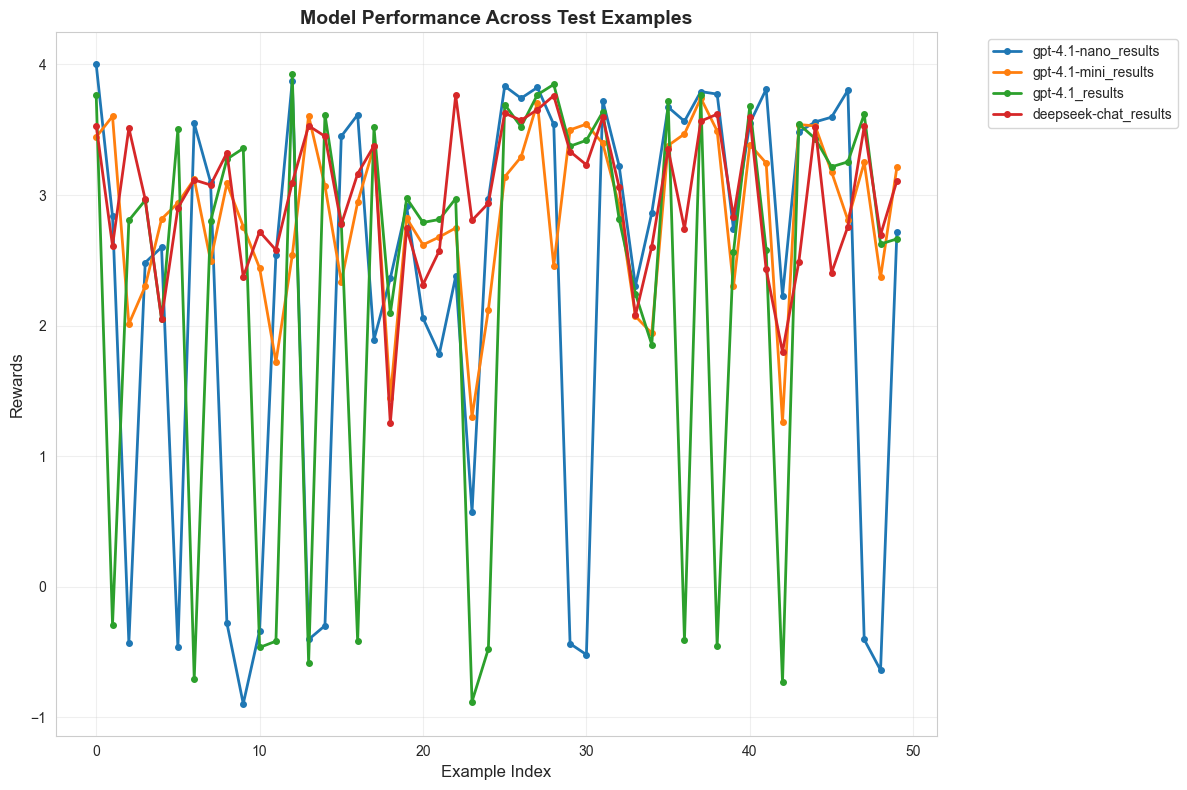

In [86]:

# Only proceed if we have data
if not df.empty:
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each model as a separate line
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        plt.plot(model_data['index'], model_data['rewards'], 
                 label=model, marker='o', markersize=4, linewidth=2)
    
    plt.xlabel('Example Index', fontsize=12)
    plt.ylabel('Rewards', fontsize=12)
    plt.title('Model Performance Across Test Examples', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No result files found. Make sure you have results_*.jsonl files in the current directory.")

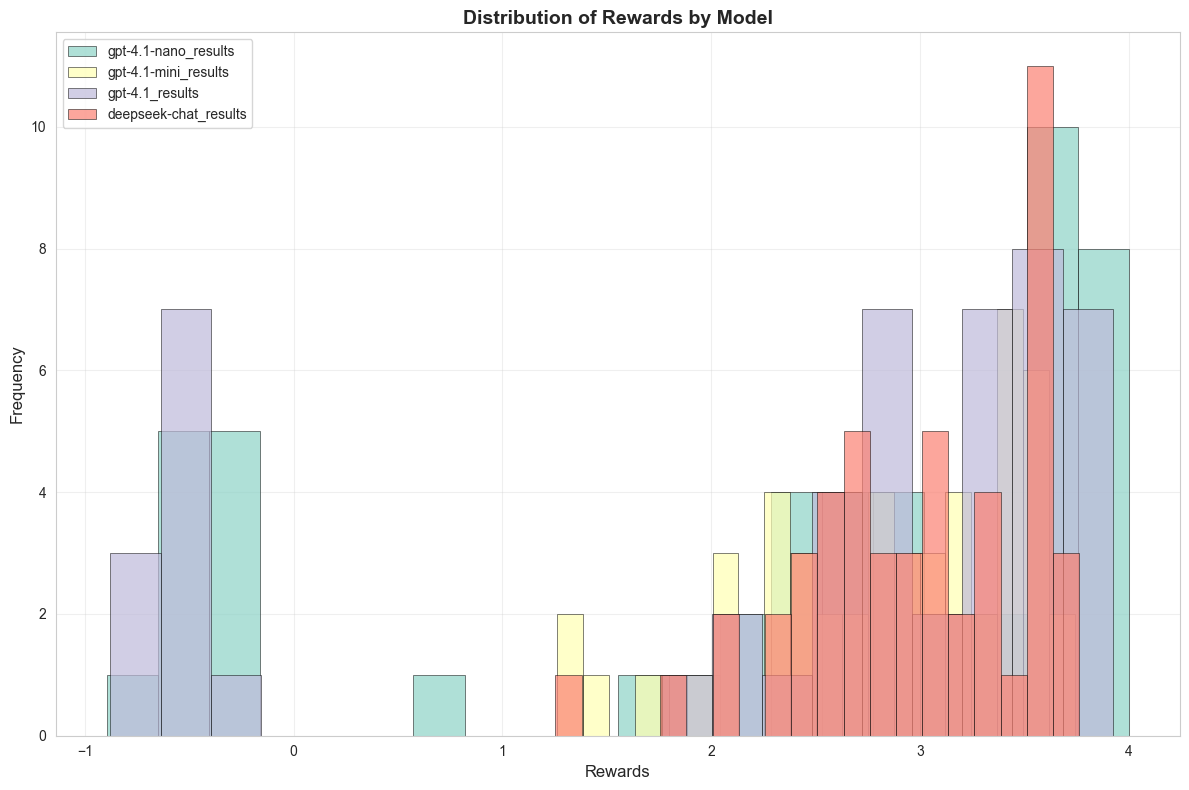


Summary Statistics by Model:

gpt-4.1-nano_results:
  Mean: 2.305
  Std:  1.630
  Min:  -0.895
  Max:  4.001
  Count: 50

gpt-4.1-mini_results:
  Mean: 2.850
  Std:  0.645
  Min:  1.263
  Max:  3.742
  Count: 50

gpt-4.1_results:
  Mean: 2.341
  Std:  1.616
  Min:  -0.878
  Max:  3.923
  Count: 50

deepseek-chat_results:
  Mean: 2.990
  Std:  0.555
  Min:  1.254
  Max:  3.763
  Count: 50


In [87]:
# Create histogram to compare reward distributions across models
if not df.empty:
    plt.figure(figsize=(12, 8))
    
    # Get unique models and create histogram
    models = df['model'].unique()
    colors = plt.cm.Set3(range(len(models)))
    
    # Create histogram with overlapping distributions
    for i, model in enumerate(models):
        model_rewards = df[df['model'] == model]['rewards']
        plt.hist(model_rewards, bins=20, alpha=0.7, label=model, 
                color=colors[i], edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Rewards', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Rewards by Model', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics by Model:")
    print("=" * 50)
    for model in models:
        model_rewards = df[df['model'] == model]['rewards']
        print(f"\n{model}:")
        print(f"  Mean: {model_rewards.mean():.3f}")
        print(f"  Std:  {model_rewards.std():.3f}")
        print(f"  Min:  {model_rewards.min():.3f}")
        print(f"  Max:  {model_rewards.max():.3f}")
        print(f"  Count: {len(model_rewards)}")
else:
    print("No data available for histogram.")


Retrieval Reward Only

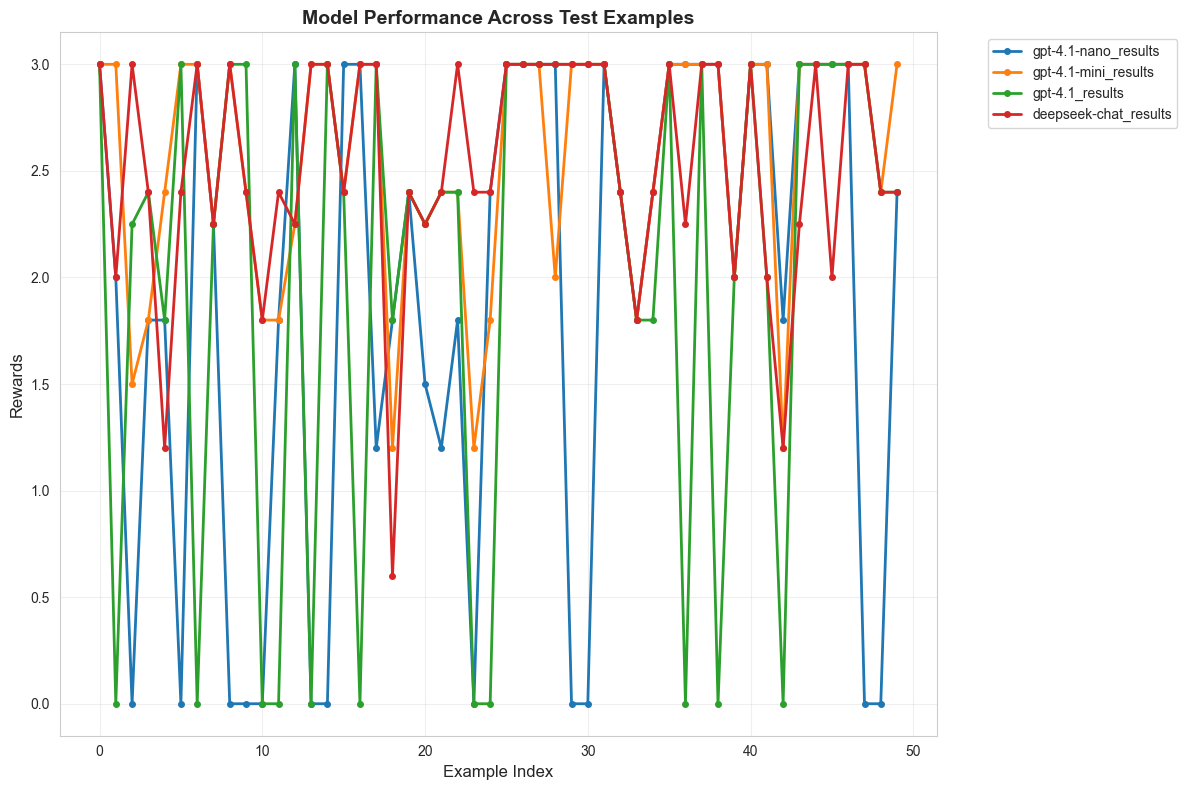

In [88]:

# Only proceed if we have data
if not df.empty:
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each model as a separate line
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        plt.plot(model_data['index'], model_data['retrieval_reward'], 
                 label=model, marker='o', markersize=4, linewidth=2)
    
    plt.xlabel('Example Index', fontsize=12)
    plt.ylabel('Rewards', fontsize=12)
    plt.title('Model Performance Across Test Examples', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No result files found. Make sure you have results_*.jsonl files in the current directory.")

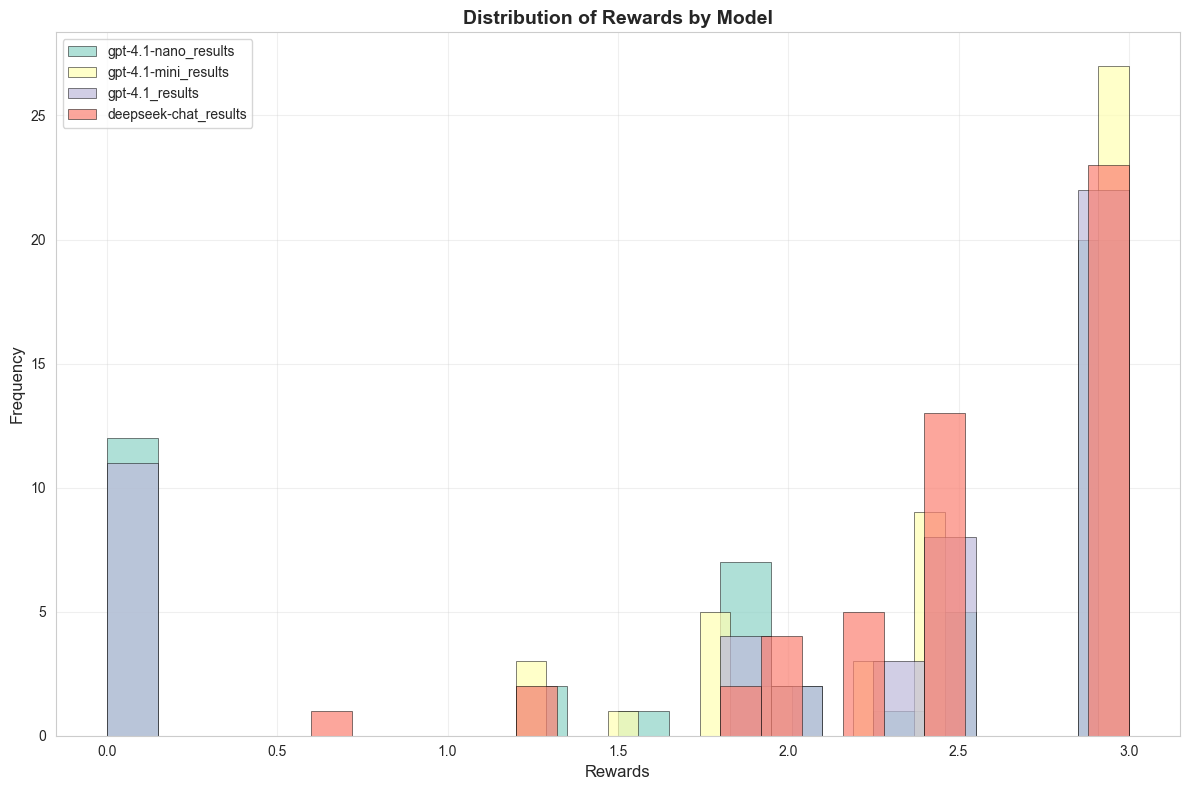


Summary Statistics by Model:

gpt-4.1-nano_results:
  Mean: 1.895
  Std:  1.196
  Min:  0.000
  Max:  3.000
  Count: 50

gpt-4.1-mini_results:
  Mean: 2.549
  Std:  0.570
  Min:  1.200
  Max:  3.000
  Count: 50

gpt-4.1_results:
  Mean: 2.063
  Std:  1.173
  Min:  0.000
  Max:  3.000
  Count: 50

deepseek-chat_results:
  Mean: 2.521
  Std:  0.556
  Min:  0.600
  Max:  3.000
  Count: 50


In [89]:
# Create histogram to compare reward distributions across models
if not df.empty:
    plt.figure(figsize=(12, 8))
    
    # Get unique models and create histogram
    models = df['model'].unique()
    colors = plt.cm.Set3(range(len(models)))
    
    # Create histogram with overlapping distributions
    for i, model in enumerate(models):
        model_rewards = df[df['model'] == model]['retrieval_reward']
        plt.hist(model_rewards, bins=20, alpha=0.7, label=model, 
                color=colors[i], edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Rewards', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Rewards by Model', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics by Model:")
    print("=" * 50)
    for model in models:
        model_rewards = df[df['model'] == model]['retrieval_reward']
        print(f"\n{model}:")
        print(f"  Mean: {model_rewards.mean():.3f}")
        print(f"  Std:  {model_rewards.std():.3f}")
        print(f"  Min:  {model_rewards.min():.3f}")
        print(f"  Max:  {model_rewards.max():.3f}")
        print(f"  Count: {len(model_rewards)}")
else:
    print("No data available for histogram.")
